<a href="https://colab.research.google.com/github/olaysco/stroke-prediction-system/blob/main/stoke_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [78]:
!pip install scikit-learn --upgrade
!pip show scikit-learn

Name: scikit-learn
Version: 1.7.2
Summary: A set of python modules for machine learning and data mining
Home-page: https://scikit-learn.org
Author: 
Author-email: 
License: 
Location: /usr/local/lib/python3.12/dist-packages
Requires: joblib, numpy, scipy, threadpoolctl
Required-by: cuml-cu12, fastai, hdbscan, imbalanced-learn, libpysal, librosa, mlxtend, pynndescent, sentence-transformers, shap, sklearn-pandas, tsfresh, umap-learn, yellowbrick


In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix,classification_report, precision_score, recall_score, roc_auc_score, average_precision_score
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
import joblib
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

results = {}

## Configuration & Helper Methods

In [80]:
# Load data sets
data=pd.read_csv('/content/drive/MyDrive/AIDatasets/dataset1.csv', encoding='ascii')
# Load data sets 2
data2=pd.read_csv('/content/drive/MyDrive/AIDatasets/dataset2.csv', encoding='ascii')
# Load data sets 3
data3=pd.read_csv('/content/drive/MyDrive/AIDatasets/dataset3.csv', encoding='ascii')
# Load data sets 4
data4=pd.read_csv('/content/drive/MyDrive/AIDatasets/dataset4.csv', encoding='ascii')

In [81]:
def train_and_evaluate_model(model, X_train, X_test, y_train, y_test, dataset_name, model_name, results, cv=5):
    """
    Trains and evaluates a given model, performing cross-validation and storing results.

    Args:
        model: The machine learning model to train.
        X_train: Training features.
        X_test: Testing features.
        y_train: Training target.
        y_test: Testing target.
        dataset_name: Name of the dataset (e.g., 'dataset_1').
        model_name: Name of the model (e.g., 'rfc').
        results: Dictionary to store the evaluation metrics.
        cv: Number of cross-validation folds.
    """
    print(f"Training {model_name} on {dataset_name}...")

    # Perform cross-validation
    print(f"Performing {cv}-fold cross-validation for {model_name} on {dataset_name}...")
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
    cv_metrics = {
        'cv_mean_accuracy': np.mean(cv_scores),
        'cv_std_accuracy': np.std(cv_scores)
    }
    print(f"Cross-validation metrics for {model_name} on {dataset_name}:")
    for metric, value in cv_metrics.items():
        print(f"  {metric}: {value:.4f}")


    # Train the model on the full training data
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, zero_division=0),
        'recall': recall_score(y_test, y_pred, zero_division=0),
        'f1': f1_score(y_test, y_pred, zero_division=0),
        'roc_auc': roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]) if hasattr(model, 'predict_proba') else 'N/A'
    }

    print(f"Test metrics for {model_name} on {dataset_name}:")
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.4f}")

    if dataset_name not in results:
        results[dataset_name] = {}

    # Store both test and CV metrics
    results[dataset_name][model_name] = {
        'test_metrics': metrics,
        'cv_metrics': cv_metrics
        }


    # Plot Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name} on {dataset_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Dataset 1 Preprocessing and Training


In [82]:
# show the first five rows of data sets
data.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
2,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
3,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
4,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1


In [83]:
# names of the columns
data.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

In [84]:
# check tha data types of data sets
data.dtypes

,0
gender,object
age,float64
hypertension,int64
heart_disease,int64
ever_married,object
work_type,object
Residence_type,object
avg_glucose_level,float64
bmi,float64
smoking_status,object


In [85]:
# check the info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4981 entries, 0 to 4980
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             4981 non-null   object 
 1   age                4981 non-null   float64
 2   hypertension       4981 non-null   int64  
 3   heart_disease      4981 non-null   int64  
 4   ever_married       4981 non-null   object 
 5   work_type          4981 non-null   object 
 6   Residence_type     4981 non-null   object 
 7   avg_glucose_level  4981 non-null   float64
 8   bmi                4981 non-null   float64
 9   smoking_status     4981 non-null   object 
 10  stroke             4981 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 428.2+ KB


In [86]:
# statistical summary of data set
data.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,4981.000000,4981.000000,4981.000000,4981.000000,4981.000000,4981.000000
mean,43.419859,0.096165,0.055210,105.943562,28.498173,0.049789
std,22.662755,0.294848,0.228412,45.075373,6.790464,0.217531
min,0.080000,0.000000,0.000000,55.120000,14.000000,0.000000
25%,25.000000,0.000000,0.000000,77.230000,23.700000,0.000000
50%,45.000000,0.000000,0.000000,91.850000,28.100000,0.000000
75%,61.000000,0.000000,0.000000,113.860000,32.600000,0.000000
max,82.000000,1.000000,1.000000,271.740000,48.900000,1.000000


In [87]:
# check the how many people have smooking status
data['age'].value_counts()

,count
age,
78.00,102
57.00,92
54.00,85
79.00,84
51.00,84
...,...
1.40,3
0.48,3
0.40,2


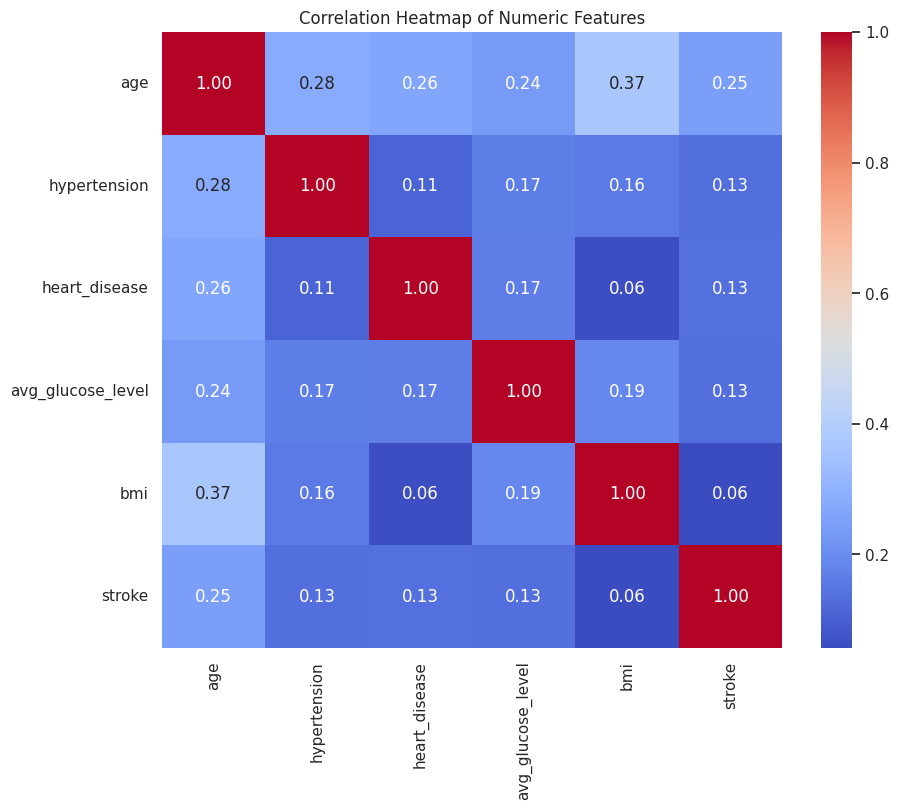

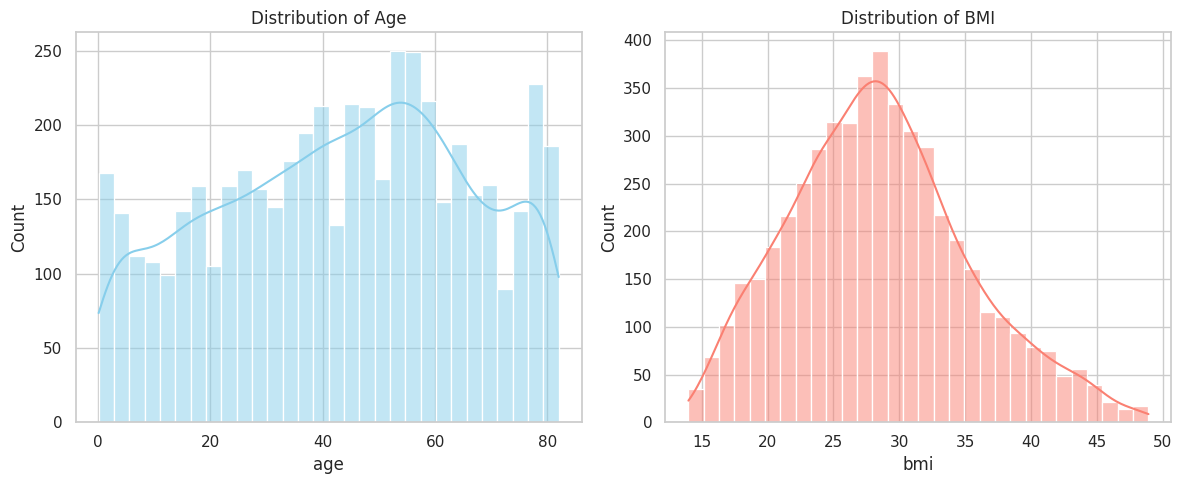

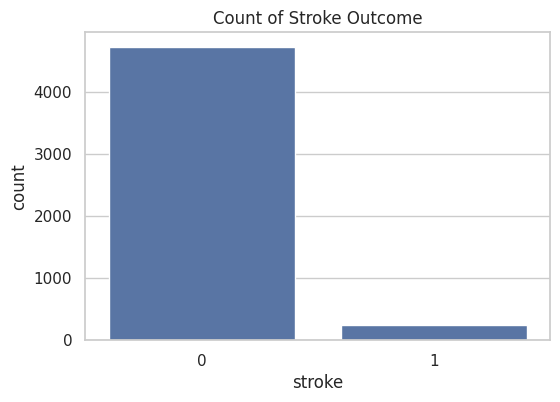

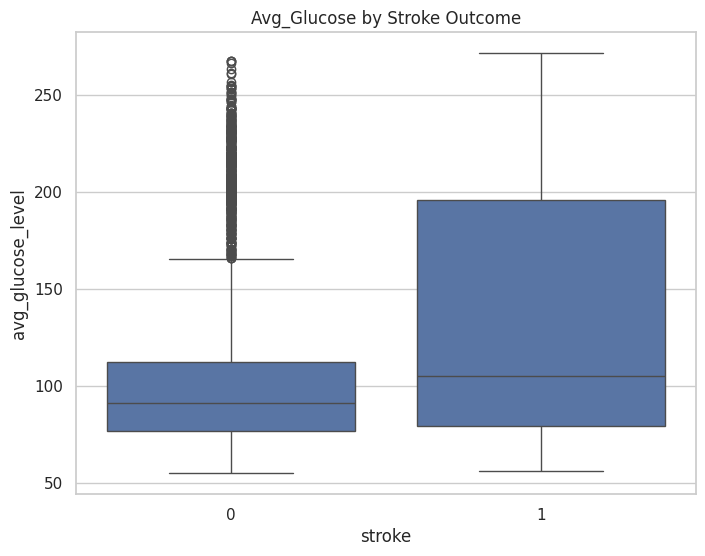

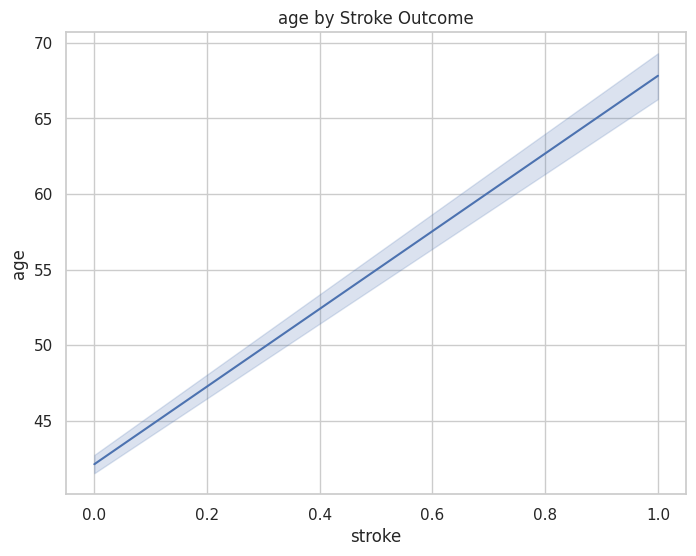

In [88]:
# Generate the correlation heatmap for numeric columns (if there are 4 or more)
numeric_data=data.select_dtypes(include=[np.number])
if numeric_data.shape[1]>4:
    plt.figure(figsize=(10,8))
    corr=numeric_data.corr()
    sns.heatmap(corr,annot=True,fmt='.2f',cmap='coolwarm')
    plt.title('Correlation Heatmap of Numeric Features')
    plt.show()

# Histogram for Age and BMI
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(data['age'], kde=True, bins=30, color='skyblue')
plt.title('Distribution of Age')

plt.subplot(1, 2, 2)
sns.histplot(data['bmi'], kde=True, bins=30, color='salmon')
plt.title('Distribution of BMI')
plt.tight_layout()
plt.show()

# Count plot for Stroke outcome
plt.figure(figsize=(6, 4))
sns.countplot(x='stroke', data=data)
plt.title('Count of Stroke Outcome')
plt.show()

# Box plot for Avg_Glucose levels grouped by Stroke outcome
plt.figure(figsize=(8, 6))
sns.boxplot(x='stroke', y='avg_glucose_level', data=data)
plt.title('Avg_Glucose by Stroke Outcome')
plt.show()


# Line plot for Age levels grouped by Stroke outcome
plt.figure(figsize=(8, 6))
sns.lineplot(x='stroke', y='age', data=data)
plt.title('age by Stroke Outcome')
plt.show()

In [89]:
# change the Strig value to numeric
encoder=LabelEncoder()
data['gender']=encoder.fit_transform(data['gender'])
data['ever_married']=encoder.fit_transform(data['ever_married'])
data['work_type']=encoder.fit_transform(data['work_type'])
data['Residence_type']=encoder.fit_transform(data['Residence_type'])
data['smoking_status']=encoder.fit_transform(data['smoking_status'])

**Feature Engnieering**

In [90]:
# divide the data i features and traget columns
X=data.drop('stroke',axis=1)
y=data['stroke']

**Model Seletion**

In [91]:
#model selection devide the data in training and testing data sets
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

**Feature Sclaing**

In [92]:
# features scaling set tha all data in specific range
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.fit_transform(X_test)
sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)

## RFC Model Training

Training RandomForest on dataset_1...
Performing 5-fold cross-validation for RandomForest on dataset_1...
Cross-validation metrics for RandomForest on dataset_1:
  cv_mean_accuracy: 0.9591
  cv_std_accuracy: 0.0183
Test metrics for RandomForest on dataset_1:
  accuracy: 0.7914
  precision: 0.0990
  recall: 0.3519
  f1: 0.1545
  roc_auc: 0.7427


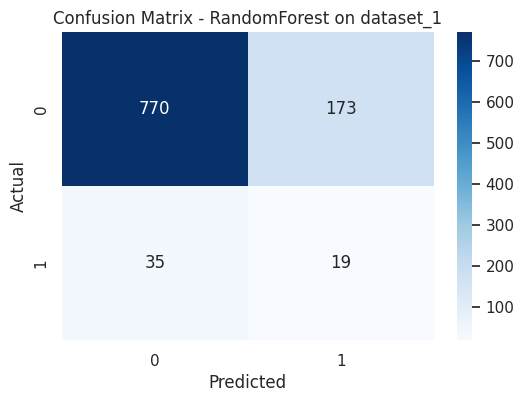

In [93]:
#train the RFC model
rfc=RandomForestClassifier(random_state=42, class_weight='balanced')
train_and_evaluate_model(rfc, X_train, X_test, y_train, y_test, 'dataset_1', 'RandomForest', results)


## SVC Model Training

Training SVM on dataset_1...
Performing 5-fold cross-validation for SVM on dataset_1...
Cross-validation metrics for SVM on dataset_1:
  cv_mean_accuracy: 0.8595
  cv_std_accuracy: 0.0068
Test metrics for SVM on dataset_1:
  accuracy: 0.7412
  precision: 0.0952
  recall: 0.4444
  f1: 0.1569
  roc_auc: 0.7245


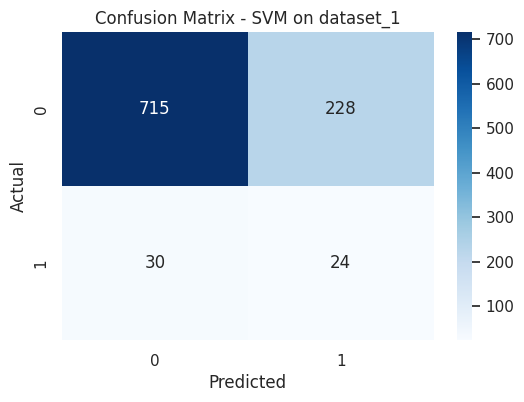

In [94]:
# train the SVM model
svm=SVC(kernel='rbf', probability=True) # Add probability=True for roc_auc
train_and_evaluate_model(svm, X_train, X_test, y_train, y_test, 'dataset_1', 'SVM', results)

## Logistic Regression Model Training

Training LogisticRegression on dataset_1...
Performing 5-fold cross-validation for LogisticRegression on dataset_1...
Cross-validation metrics for LogisticRegression on dataset_1:
  cv_mean_accuracy: 0.7810
  cv_std_accuracy: 0.0071
Test metrics for LogisticRegression on dataset_1:
  accuracy: 0.7372
  precision: 0.1438
  recall: 0.7778
  f1: 0.2428
  roc_auc: 0.8451


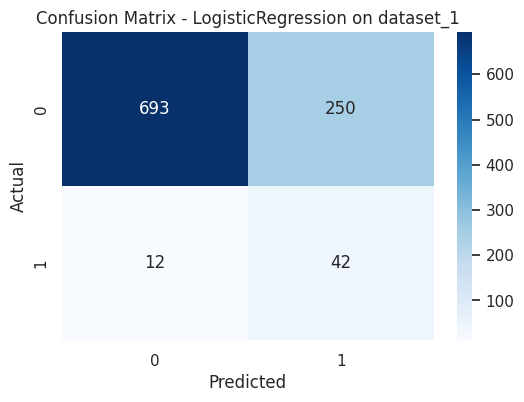

In [95]:
# train the LR model
lr = LogisticRegression(max_iter=200, class_weight='balanced', n_jobs=None)
train_and_evaluate_model(lr, X_train, X_test, y_train, y_test, 'dataset_1', 'LogisticRegression', results)

## XGBoost Model Training

Training XGBClassifier on dataset_1...
Performing 5-fold cross-validation for XGBClassifier on dataset_1...
Cross-validation metrics for XGBClassifier on dataset_1:
  cv_mean_accuracy: 0.9554
  cv_std_accuracy: 0.0272
Test metrics for XGBClassifier on dataset_1:
  accuracy: 0.4433
  precision: 0.0846
  recall: 0.9444
  f1: 0.1553
  roc_auc: 0.7745


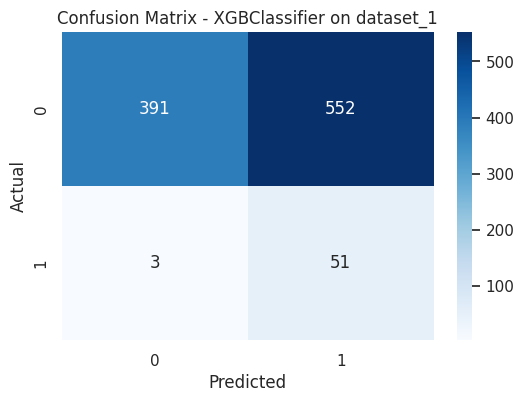

In [96]:
xgb=XGBClassifier(n_estimators=200, random_state=42)
train_and_evaluate_model(xgb, X_train, X_test, y_train, y_test, 'dataset_1', 'XGBClassifier', results)

# Dataset 2 Preprocessing and Training


In [97]:
# show the first five rows of data sets
data2.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [98]:
# names of the columns
data2.columns

Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

In [99]:
# check tha data types of data sets
data2.dtypes

,0
id,int64
gender,object
age,float64
hypertension,int64
heart_disease,int64
ever_married,object
work_type,object
Residence_type,object
avg_glucose_level,float64
bmi,float64


In [100]:
# check the info
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [101]:
# statistical summary of data set
data2.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [102]:
# drop unused column
data2.drop('id',axis=1,inplace=True)

In [103]:
# check the how many people have smooking status
data2['age'].value_counts()

,count
age,
78.00,102
57.00,95
52.00,90
54.00,87
51.00,86
...,...
1.40,3
0.48,3
0.16,3


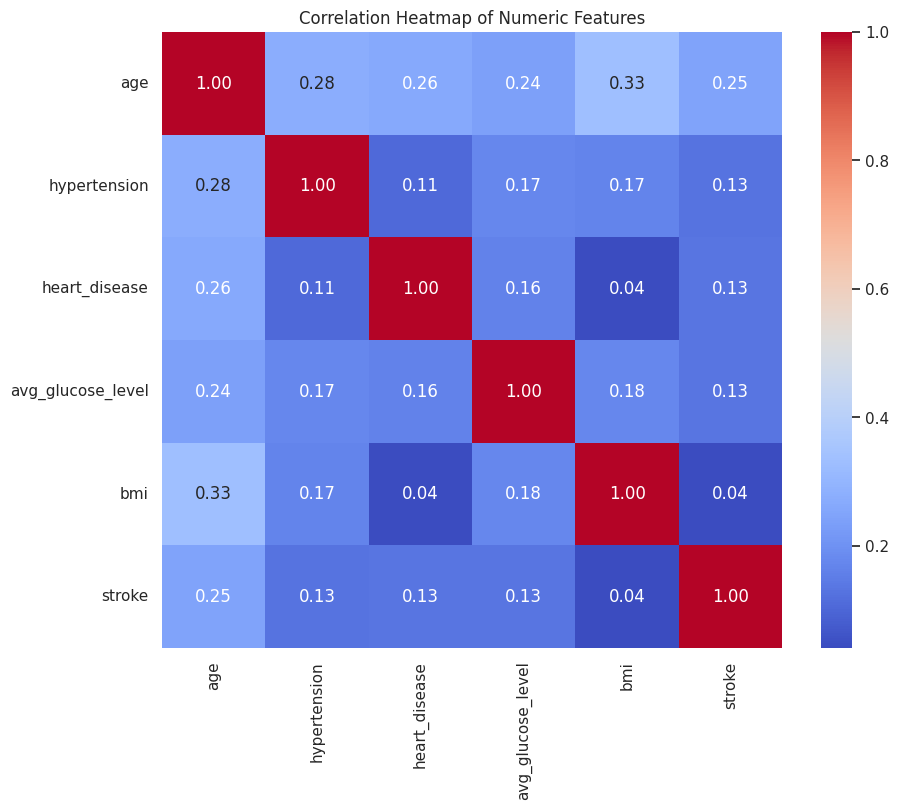

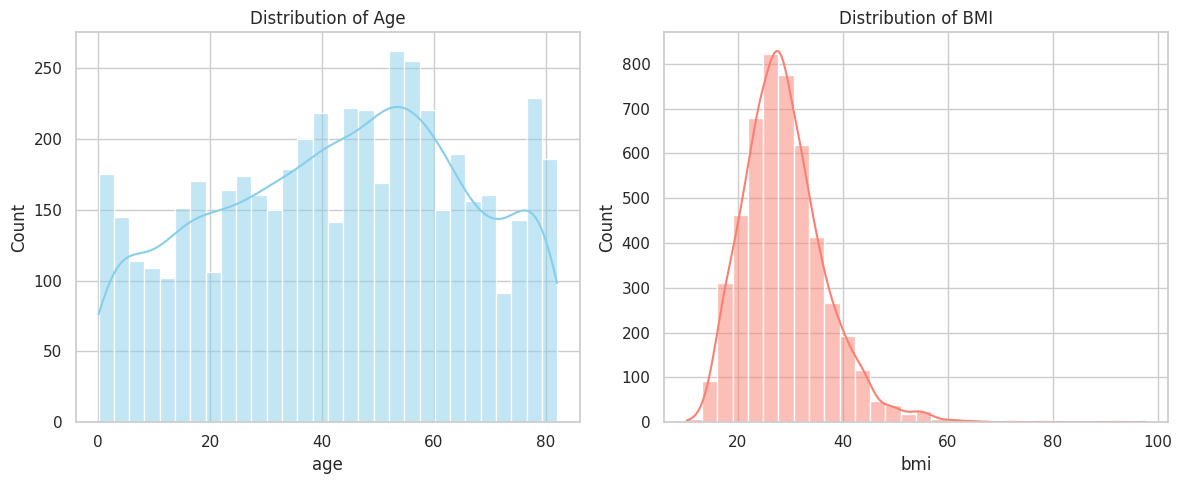

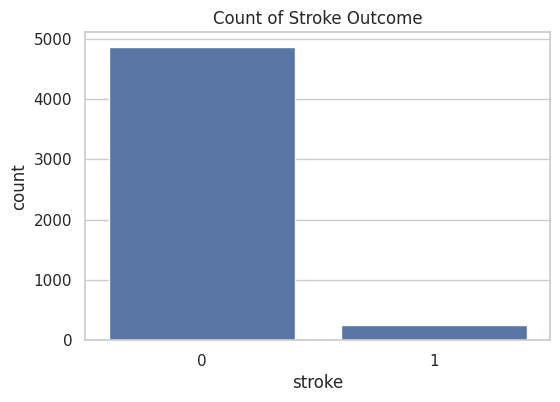

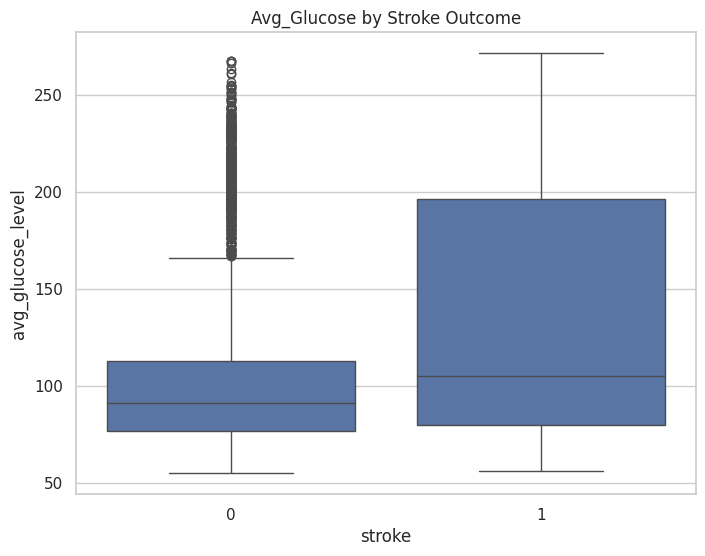

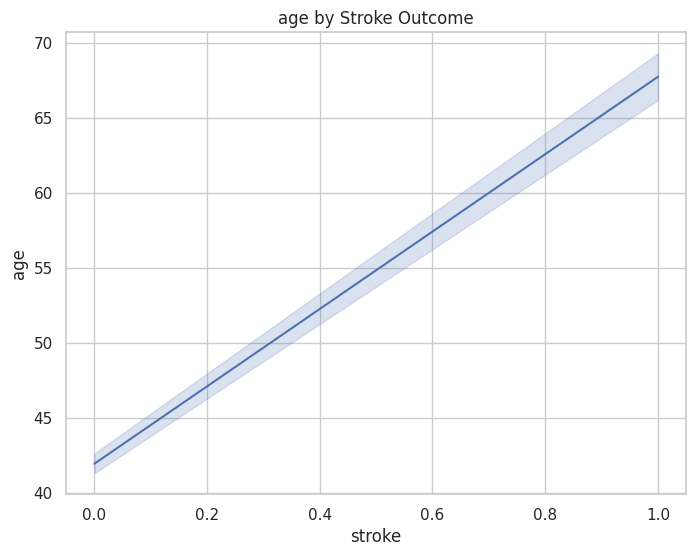

In [104]:
# Generate the correlation heatmap for numeric columns (if there are 4 or more)
numeric_data2=data2.select_dtypes(include=[np.number])
if numeric_data2.shape[1]>4:
    plt.figure(figsize=(10,8))
    corr=numeric_data2.corr()
    sns.heatmap(corr,annot=True,fmt='.2f',cmap='coolwarm')
    plt.title('Correlation Heatmap of Numeric Features')
    plt.show()

# Histogram for Age and BMI
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(data2['age'], kde=True, bins=30, color='skyblue')
plt.title('Distribution of Age')

plt.subplot(1, 2, 2)
sns.histplot(data2['bmi'], kde=True, bins=30, color='salmon')
plt.title('Distribution of BMI')
plt.tight_layout()
plt.show()

# Count plot for Stroke outcome
plt.figure(figsize=(6, 4))
sns.countplot(x='stroke', data=data2)
plt.title('Count of Stroke Outcome')
plt.show()

# Box plot for Avg_Glucose levels grouped by Stroke outcome
plt.figure(figsize=(8, 6))
sns.boxplot(x='stroke', y='avg_glucose_level', data=data2)
plt.title('Avg_Glucose by Stroke Outcome')
plt.show()

# Line plot for Age levels grouped by Stroke outcome
plt.figure(figsize=(8, 6))
sns.lineplot(x='stroke', y='age', data=data2)
plt.title('age by Stroke Outcome')
plt.show()

In [105]:
# change the Strig value to numeric
encoder=LabelEncoder()
data['gender']=encoder.fit_transform(data['gender'])
data['ever_married']=encoder.fit_transform(data['ever_married'])
data['work_type']=encoder.fit_transform(data['work_type'])
data['Residence_type']=encoder.fit_transform(data['Residence_type'])
data['avg_glucose_level']=encoder.fit_transform(data['avg_glucose_level'])
data['smoking_status']=encoder.fit_transform(data['smoking_status'])

**Feature Engnieering**

In [106]:
# divide the data i features and traget columns
X=data.drop('stroke',axis=1)
y=data['stroke']

**Model Seletion**

In [107]:
#model selection devide the data in training and testing data sets
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

**Feature Sclaing**

In [108]:
# features scaling set tha all data in specific range
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.fit_transform(X_test)
sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)

## RFC Model Training

Training RandomForest on dataset_2...
Performing 5-fold cross-validation for RandomForest on dataset_2...
Cross-validation metrics for RandomForest on dataset_2:
  cv_mean_accuracy: 0.9607
  cv_std_accuracy: 0.0189
Test metrics for RandomForest on dataset_2:
  accuracy: 0.7673
  precision: 0.1096
  recall: 0.4630
  f1: 0.1773
  roc_auc: 0.7520


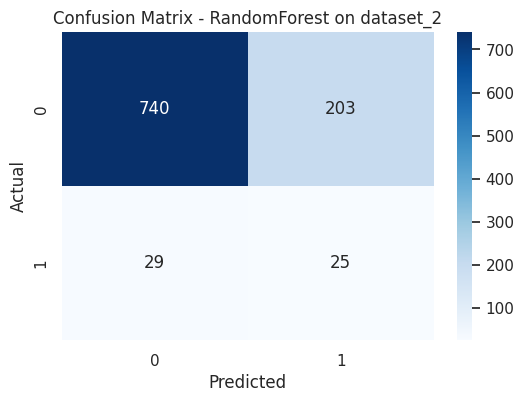

In [109]:
#train the RFC model
rfc=RandomForestClassifier(n_estimators=100,random_state=42)
train_and_evaluate_model(rfc, X_train, X_test, y_train, y_test, 'dataset_2', 'RandomForest', results)

## SVC Model Training

Training SVC on dataset_2...
Performing 5-fold cross-validation for SVC on dataset_2...
Cross-validation metrics for SVC on dataset_2:
  cv_mean_accuracy: 0.8602
  cv_std_accuracy: 0.0067
Test metrics for SVC on dataset_2:
  accuracy: 0.7533
  precision: 0.1000
  recall: 0.4444
  f1: 0.1633
  roc_auc: 0.7252


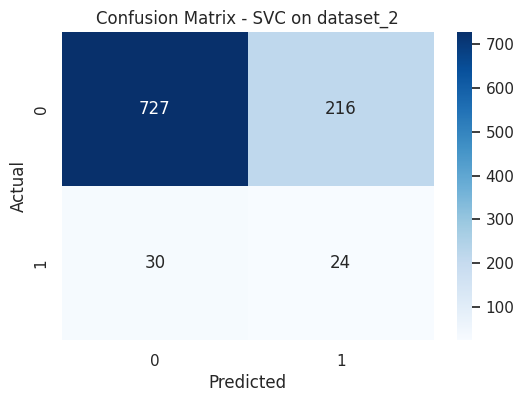

In [110]:
# train the SVC model
svc=SVC(kernel='rbf', probability=True)
train_and_evaluate_model(svc, X_train, X_test, y_train, y_test, 'dataset_2', 'SVC', results)

## Logistic Regression Model Training

Training LogisticRegression on dataset_2...
Performing 5-fold cross-validation for LogisticRegression on dataset_2...
Cross-validation metrics for LogisticRegression on dataset_2:
  cv_mean_accuracy: 0.7838
  cv_std_accuracy: 0.0051
Test metrics for LogisticRegression on dataset_2:
  accuracy: 0.7402
  precision: 0.1525
  recall: 0.8333
  f1: 0.2579
  roc_auc: 0.8429


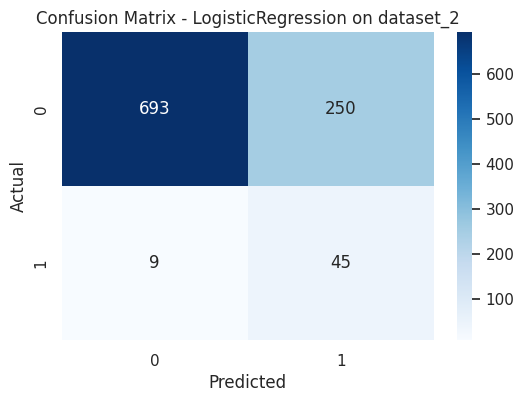

In [111]:
# train the LR model
lr = LogisticRegression(max_iter=200, class_weight='balanced', n_jobs=None)
train_and_evaluate_model(lr, X_train, X_test, y_train, y_test, 'dataset_2', 'LogisticRegression', results)

## XGBoost Model Training

Training XGBClassifier on dataset_2...
Performing 5-fold cross-validation for XGBClassifier on dataset_2...
Cross-validation metrics for XGBClassifier on dataset_2:
  cv_mean_accuracy: 0.9561
  cv_std_accuracy: 0.0262
Test metrics for XGBClassifier on dataset_2:
  accuracy: 0.4173
  precision: 0.0824
  recall: 0.9630
  f1: 0.1518
  roc_auc: 0.7455


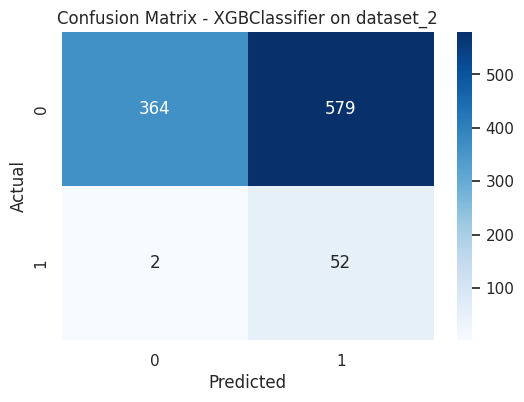

In [112]:
xgb=XGBClassifier(n_estimators=200, random_state=42)
train_and_evaluate_model(xgb, X_train, X_test, y_train, y_test, 'dataset_2', 'XGBClassifier', results)

# Dataset 3 Preprocessing and Training


In [113]:
# show the first five rows of data sets
data3.head()

,ID,Gender,Age,Hypertension,Heart_Disease,Ever_Married,Work_Type,Residence_Type,Avg_Glucose_Level,BMI,Smoking_Status,Stroke
0,30669,Male,3.0,0,0,No,children,Rural,95.12,18.0,NaN,0
1,30468,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
2,16523,Female,8.0,0,0,No,Private,Urban,110.89,17.6,NaN,0
3,56543,Female,70.0,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0
4,46136,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,NaN,0


In [114]:
# names of the columns
data3.columns

Index(['ID', 'Gender', 'Age', 'Hypertension', 'Heart_Disease', 'Ever_Married',
       'Work_Type', 'Residence_Type', 'Avg_Glucose_Level', 'BMI',
       'Smoking_Status', 'Stroke'],
      dtype='object')

In [115]:
# check tha data types of data sets
data3.dtypes

,0
ID,int64
Gender,object
Age,float64
Hypertension,int64
Heart_Disease,int64
Ever_Married,object
Work_Type,object
Residence_Type,object
Avg_Glucose_Level,float64
BMI,float64


In [116]:
# check the info
data3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43400 entries, 0 to 43399
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ID                 43400 non-null  int64  
 1   Gender             43400 non-null  object 
 2   Age                43400 non-null  float64
 3   Hypertension       43400 non-null  int64  
 4   Heart_Disease      43400 non-null  int64  
 5   Ever_Married       43400 non-null  object 
 6   Work_Type          43400 non-null  object 
 7   Residence_Type     43400 non-null  object 
 8   Avg_Glucose_Level  43400 non-null  float64
 9   BMI                41938 non-null  float64
 10  Smoking_Status     30108 non-null  object 
 11  Stroke             43400 non-null  int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 4.0+ MB


In [117]:
# statistical summary of data set
data3.describe()

,ID,Age,Hypertension,Heart_Disease,Avg_Glucose_Level,BMI,Stroke
count,43400.000000,43400.000000,43400.000000,43400.000000,43400.000000,41938.000000,43400.000000
mean,36326.142350,42.217894,0.093571,0.047512,104.482750,28.605038,0.018041
std,21072.134879,22.519649,0.291235,0.212733,43.111751,7.770020,0.133103
min,1.000000,0.080000,0.000000,0.000000,55.000000,10.100000,0.000000
25%,18038.500000,24.000000,0.000000,0.000000,77.540000,23.200000,0.000000
50%,36351.500000,44.000000,0.000000,0.000000,91.580000,27.700000,0.000000
75%,54514.250000,60.000000,0.000000,0.000000,112.070000,32.900000,0.000000
max,72943.000000,82.000000,1.000000,1.000000,291.050000,97.600000,1.000000


In [118]:
data3.drop('ID',axis=1,inplace=True)

In [119]:
# statistical summary of data set
data3.describe()

,Age,Hypertension,Heart_Disease,Avg_Glucose_Level,BMI,Stroke
count,43400.000000,43400.000000,43400.000000,43400.000000,41938.000000,43400.000000
mean,42.217894,0.093571,0.047512,104.482750,28.605038,0.018041
std,22.519649,0.291235,0.212733,43.111751,7.770020,0.133103
min,0.080000,0.000000,0.000000,55.000000,10.100000,0.000000
25%,24.000000,0.000000,0.000000,77.540000,23.200000,0.000000
50%,44.000000,0.000000,0.000000,91.580000,27.700000,0.000000
75%,60.000000,0.000000,0.000000,112.070000,32.900000,0.000000
max,82.000000,1.000000,1.000000,291.050000,97.600000,1.000000


In [120]:
# check the how many people have smooking status
data3['Age'].value_counts()

,count
Age,
51.00,738
52.00,721
53.00,701
78.00,698
50.00,694
...,...
0.48,37
0.40,35
1.00,34


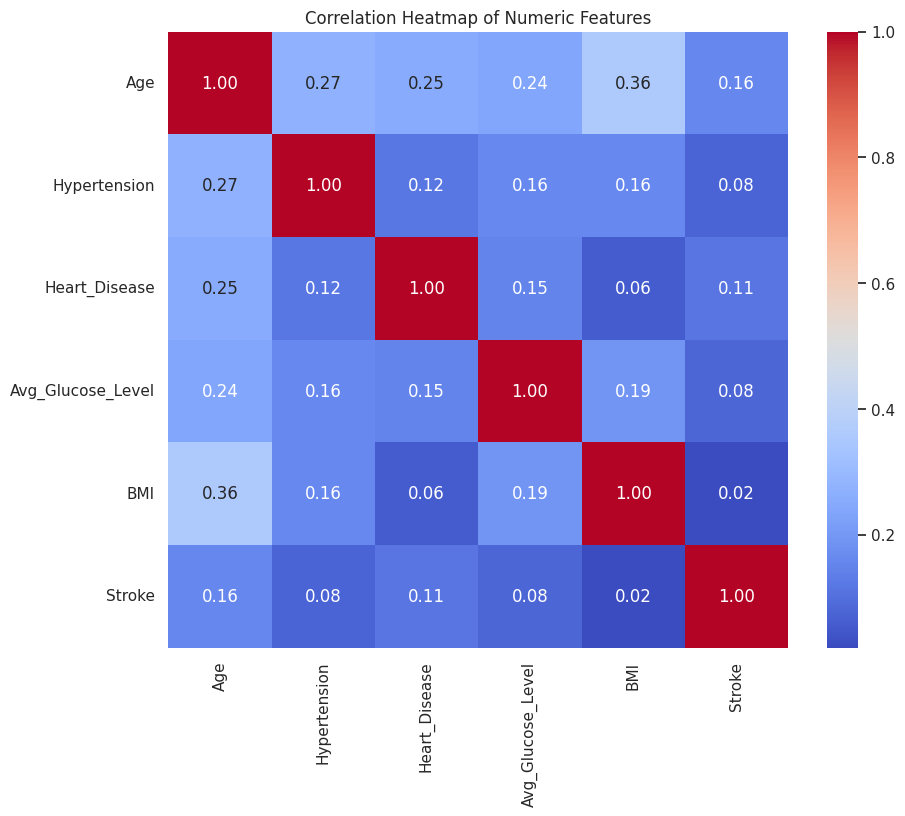

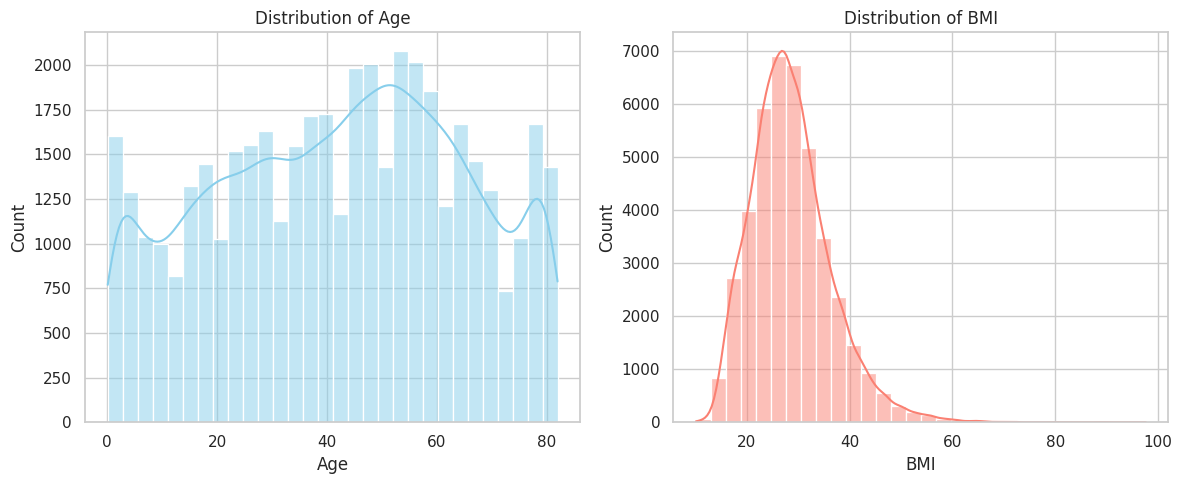

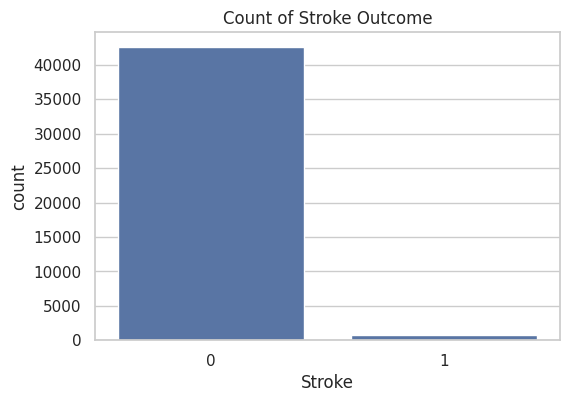

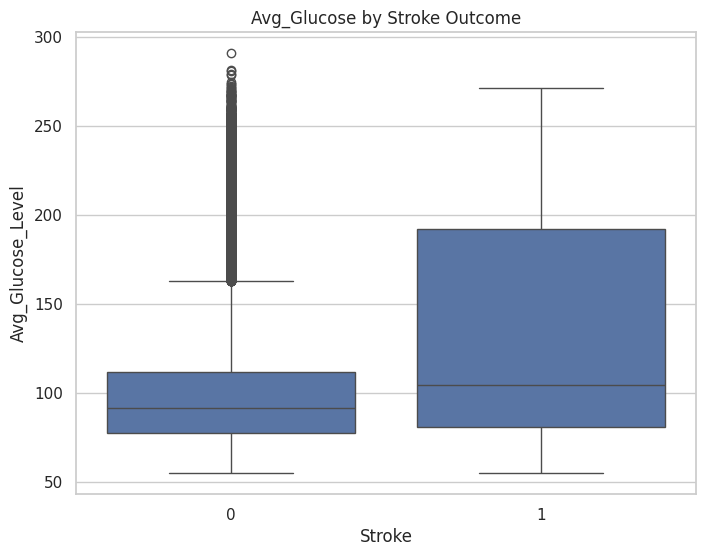

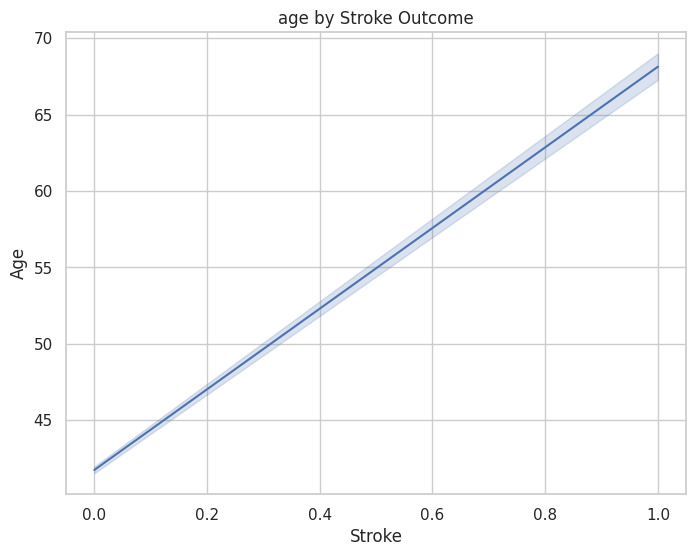

In [121]:
# Generate the correlation heatmap for numeric columns (if there are 4 or more)
numeric_data3=data3.select_dtypes(include=[np.number])
if numeric_data3.shape[1]>4:
    plt.figure(figsize=(10,8))
    corr=numeric_data3.corr()
    sns.heatmap(corr,annot=True,fmt='.2f',cmap='coolwarm')
    plt.title('Correlation Heatmap of Numeric Features')
    plt.show()

# Histogram for Age and BMI
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(data3['Age'], kde=True, bins=30, color='skyblue')
plt.title('Distribution of Age')

plt.subplot(1, 2, 2)
sns.histplot(data3['BMI'], kde=True, bins=30, color='salmon')
plt.title('Distribution of BMI')
plt.tight_layout()
plt.show()

# Count plot for Stroke outcome
plt.figure(figsize=(6, 4))
sns.countplot(x='Stroke', data=data3)
plt.title('Count of Stroke Outcome')
plt.show()

# Box plot for Avg_Glucose levels grouped by Stroke outcome
plt.figure(figsize=(8, 6))
sns.boxplot(x='Stroke', y='Avg_Glucose_Level', data=data3)
plt.title('Avg_Glucose by Stroke Outcome')
plt.show()

# Line plot for Age levels grouped by Stroke outcome
plt.figure(figsize=(8, 6))
sns.lineplot(x='Stroke', y='Age', data=data3)
plt.title('age by Stroke Outcome')
plt.show()

In [122]:
# change the Strig value to numeric
encoder=LabelEncoder()
data3['Gender']=encoder.fit_transform(data3['Gender'])
data3['Ever_Married']=encoder.fit_transform(data3['Ever_Married'])
data3['Work_Type']=encoder.fit_transform(data3['Work_Type'])
data3['Residence_Type']=encoder.fit_transform(data3['Residence_Type'])
data3['Avg_Glucose_Level']=encoder.fit_transform(data3['Avg_Glucose_Level'])
data3['Smoking_Status']=encoder.fit_transform(data3['Smoking_Status'])

**Feature Engnieering**

In [123]:
# divide the data i features and traget columns
X=data.drop('stroke',axis=1)
y=data['stroke']

**Model Seletion**

In [124]:
#model selection devide the data in training and testing data sets
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

**Feature Sclaing**

In [125]:
# features scaling set tha all data in specific range
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.fit_transform(X_test)
sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)

## RFC Model Training

Training RandomForest on dataset_3...
Performing 5-fold cross-validation for RandomForest on dataset_3...
Cross-validation metrics for RandomForest on dataset_3:
  cv_mean_accuracy: 0.9607
  cv_std_accuracy: 0.0189
Test metrics for RandomForest on dataset_3:
  accuracy: 0.7673
  precision: 0.1096
  recall: 0.4630
  f1: 0.1773
  roc_auc: 0.7520


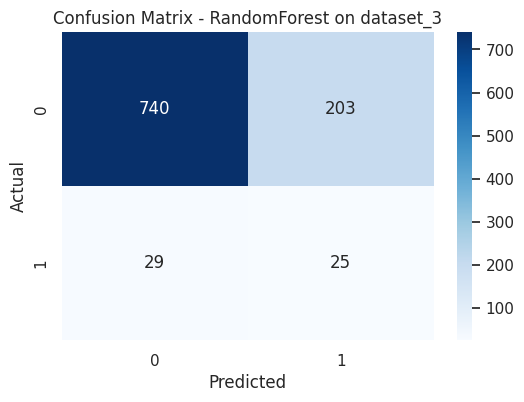

In [126]:
#train the RFC model
rfc=RandomForestClassifier(n_estimators=100,random_state=42)
train_and_evaluate_model(rfc, X_train, X_test, y_train, y_test, 'dataset_3', 'RandomForest', results)

## SVC Model Training

Training SVC on dataset_3...
Performing 5-fold cross-validation for SVC on dataset_3...
Cross-validation metrics for SVC on dataset_3:
  cv_mean_accuracy: 0.8602
  cv_std_accuracy: 0.0067
Test metrics for SVC on dataset_3:
  accuracy: 0.7533
  precision: 0.1000
  recall: 0.4444
  f1: 0.1633
  roc_auc: 0.7252


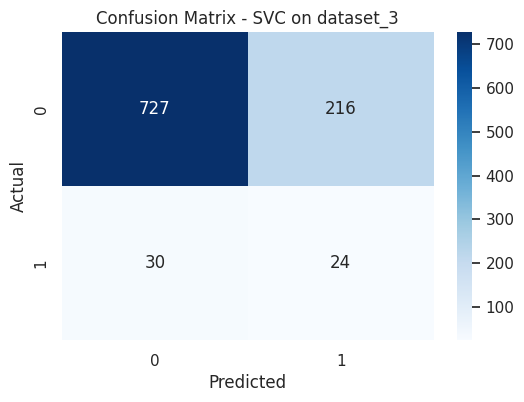

In [127]:
# train the SVC model
svc=SVC(kernel='rbf', probability=True)
train_and_evaluate_model(svc, X_train, X_test, y_train, y_test, 'dataset_3', 'SVC', results)

## Logistic Regression Model Training

Training LogisticRegression on dataset_3...
Performing 5-fold cross-validation for LogisticRegression on dataset_3...
Cross-validation metrics for LogisticRegression on dataset_3:
  cv_mean_accuracy: 0.7838
  cv_std_accuracy: 0.0051
Test metrics for LogisticRegression on dataset_3:
  accuracy: 0.7402
  precision: 0.1525
  recall: 0.8333
  f1: 0.2579
  roc_auc: 0.8429


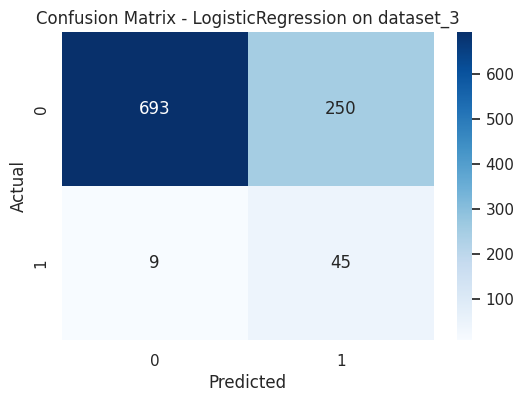

In [128]:
# train the LR model
lr = LogisticRegression(max_iter=200, class_weight='balanced', n_jobs=None)
train_and_evaluate_model(lr, X_train, X_test, y_train, y_test, 'dataset_3', 'LogisticRegression', results)

## XGBoost Model Training

Training XGBClassifier on dataset_3...
Performing 5-fold cross-validation for XGBClassifier on dataset_3...
Cross-validation metrics for XGBClassifier on dataset_3:
  cv_mean_accuracy: 0.9561
  cv_std_accuracy: 0.0262
Test metrics for XGBClassifier on dataset_3:
  accuracy: 0.4173
  precision: 0.0824
  recall: 0.9630
  f1: 0.1518
  roc_auc: 0.7455


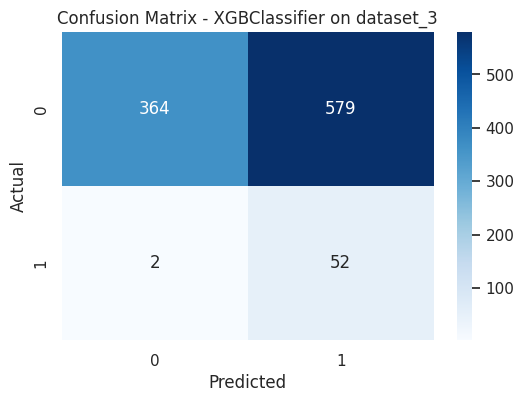

In [129]:
xgb=XGBClassifier(n_estimators=200, random_state=42)
train_and_evaluate_model(xgb, X_train, X_test, y_train, y_test, 'dataset_3', 'XGBClassifier', results)

# Dataset 4 Preprocessing and Training


In [130]:
# show the first five rows of data sets
data4.head()

,Age,Gender,SES,Hypertension,Heart_Disease,BMI,Avg_Glucose,Diabetes,Smoking_Status,Stroke
0,66.788137,Male,Medium,1,0,25.842521,96.428681,1,Current,1
1,86.393609,Female,Medium,1,1,32.531061,133.350068,0,Never,1
2,76.158579,Female,Medium,1,0,40.681244,111.489589,0,Never,0
3,72.477870,Female,Low,0,1,33.003193,125.692465,0,Former,0
4,59.881635,Male,Low,0,0,26.062443,123.218486,1,Never,1


In [131]:
# names of the columns
data4.columns

Index(['Age', 'Gender', 'SES', 'Hypertension', 'Heart_Disease', 'BMI',
       'Avg_Glucose', 'Diabetes', 'Smoking_Status', 'Stroke'],
      dtype='object')

In [132]:
# check tha data types of data sets
data4.dtypes

,0
Age,float64
Gender,object
SES,object
Hypertension,int64
Heart_Disease,int64
BMI,float64
Avg_Glucose,float64
Diabetes,int64
Smoking_Status,object
Stroke,int64


In [133]:
# check the info
data4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             10000 non-null  float64
 1   Gender          10000 non-null  object 
 2   SES             10000 non-null  object 
 3   Hypertension    10000 non-null  int64  
 4   Heart_Disease   10000 non-null  int64  
 5   BMI             10000 non-null  float64
 6   Avg_Glucose     10000 non-null  float64
 7   Diabetes        10000 non-null  int64  
 8   Smoking_Status  10000 non-null  object 
 9   Stroke          10000 non-null  int64  
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB


In [134]:
# statistical summary of data set
data4.describe()

,Age,Hypertension,Heart_Disease,BMI,Avg_Glucose,Diabetes,Stroke
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,69.757847,0.605800,0.302800,28.042252,109.115918,0.196000,0.297800
std,9.869468,0.488703,0.459492,4.901424,16.421142,0.396988,0.457314
min,27.706561,0.000000,0.000000,15.037988,45.569135,0.000000,0.000000
25%,63.128574,0.000000,0.000000,24.660786,98.188349,0.000000,0.000000
50%,69.796042,1.000000,0.000000,28.066932,109.022208,0.000000,0.000000
75%,76.402885,1.000000,1.000000,31.390170,120.341179,0.000000,1.000000
max,99.417448,1.000000,1.000000,47.495955,176.180688,1.000000,1.000000


In [135]:
# check the how many people have smooking status
data4['Age'].value_counts()

,count
Age,
83.321557,1
65.086238,1
72.598524,1
66.239181,1
73.408627,1
...,...
59.881635,1
72.477870,1
76.158579,1


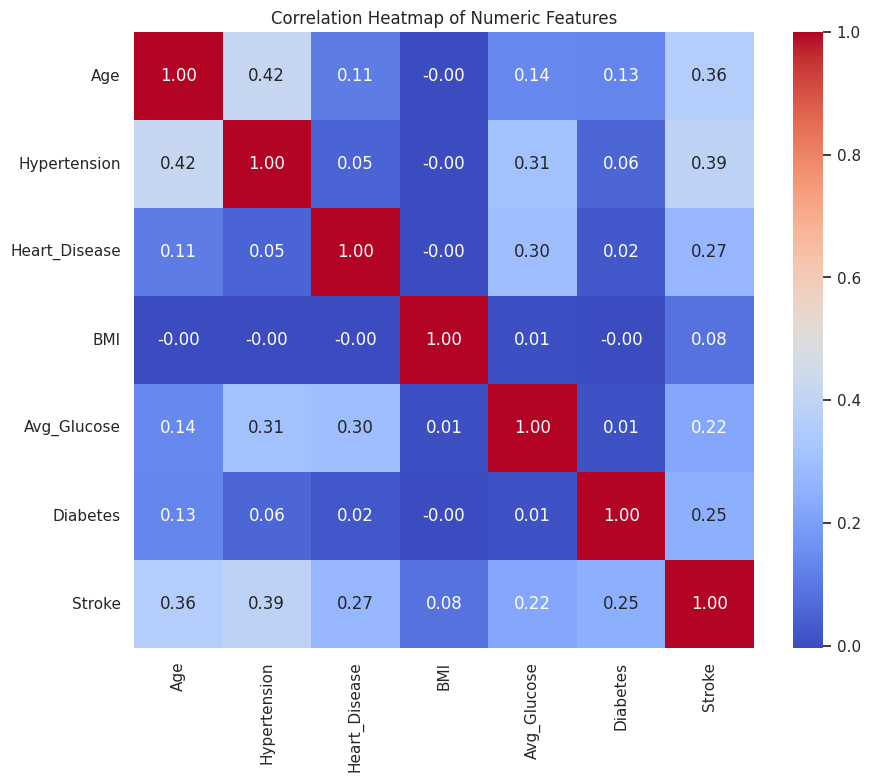

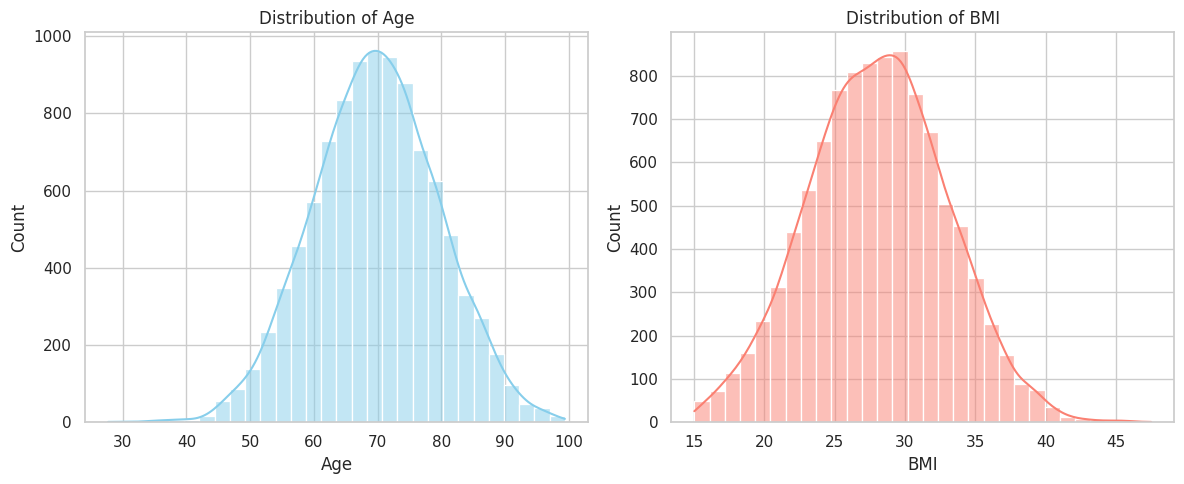

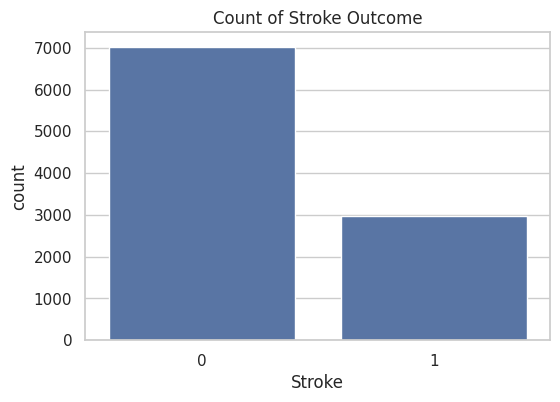

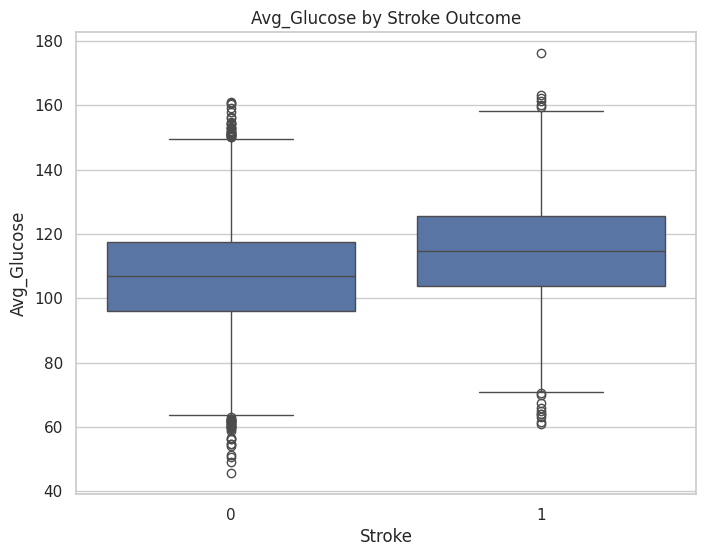

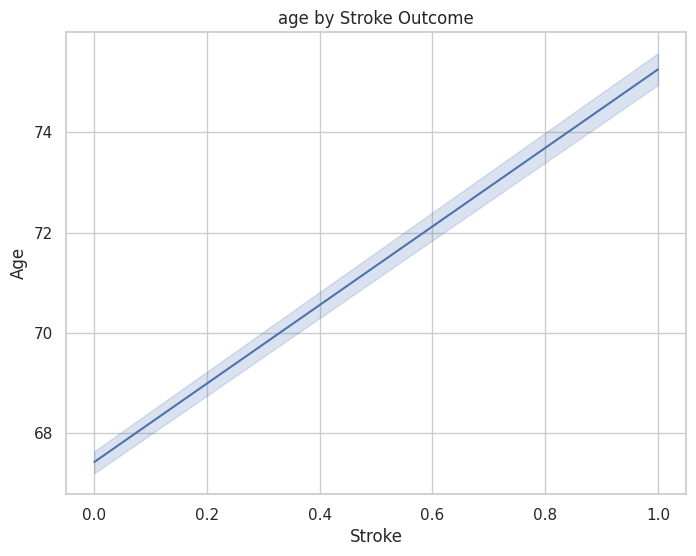

In [136]:
# Generate the correlation heatmap for numeric columns (if there are 4 or more)
numeric_data4=data4.select_dtypes(include=[np.number])
if numeric_data4.shape[1]>4:
    plt.figure(figsize=(10,8))
    corr=numeric_data4.corr()
    sns.heatmap(corr,annot=True,fmt='.2f',cmap='coolwarm')
    plt.title('Correlation Heatmap of Numeric Features')
    plt.show()

# Histogram for Age and BMI
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(data4['Age'], kde=True, bins=30, color='skyblue')
plt.title('Distribution of Age')

plt.subplot(1, 2, 2)
sns.histplot(data4['BMI'], kde=True, bins=30, color='salmon')
plt.title('Distribution of BMI')
plt.tight_layout()
plt.show()

# Count plot for Stroke outcome
plt.figure(figsize=(6, 4))
sns.countplot(x='Stroke', data=data4)
plt.title('Count of Stroke Outcome')
plt.show()

# Box plot for Avg_Glucose levels grouped by Stroke outcome
plt.figure(figsize=(8, 6))
sns.boxplot(x='Stroke', y='Avg_Glucose', data=data4)
plt.title('Avg_Glucose by Stroke Outcome')
plt.show()

# Line plot for Age levels grouped by Stroke outcome
plt.figure(figsize=(8, 6))
sns.lineplot(x='Stroke', y='Age', data=data4)
plt.title('age by Stroke Outcome')
plt.show()

In [137]:
# change the Strig value to numeric
encoder=LabelEncoder()
data4['Gender']=encoder.fit_transform(data4['Gender'])
data4['SES']=encoder.fit_transform(data4['SES'])
data4['Smoking_Status']=encoder.fit_transform(data4['Smoking_Status'])

**Feature Engnieering**

In [138]:
# divide the data i features and traget columns
X=data4.drop('Stroke',axis=1)
y=data4['Stroke']

**Model Seletion**

In [139]:
#model selection devide the data in training and testing data sets
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

**Feature Sclaing**

In [140]:
# features scaling set tha all data in specific range
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.fit_transform(X_test)
sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)

## RFC Model Training

Training RandomForest on dataset_4...
Performing 5-fold cross-validation for RandomForest on dataset_4...
Cross-validation metrics for RandomForest on dataset_4:
  cv_mean_accuracy: 0.8286
  cv_std_accuracy: 0.0215
Test metrics for RandomForest on dataset_4:
  accuracy: 0.7445
  precision: 0.5556
  recall: 0.6474
  f1: 0.5980
  roc_auc: 0.8005


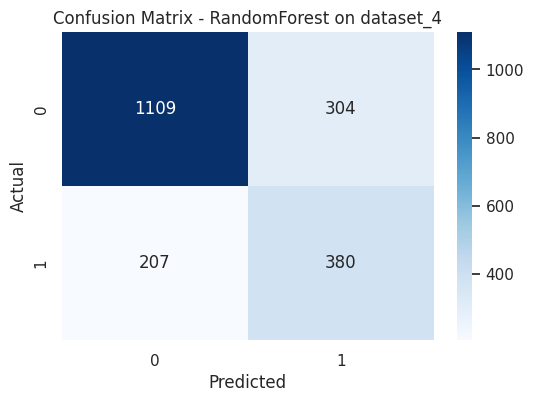

In [141]:
#train the RFC model
rfc=RandomForestClassifier(n_estimators=300,random_state=42, class_weight='balanced')
train_and_evaluate_model(rfc, X_train, X_test, y_train, y_test, 'dataset_4', 'RandomForest', results)

## SVC Model Training

Training SVC on dataset_4...
Performing 5-fold cross-validation for SVC on dataset_4...
Cross-validation metrics for SVC on dataset_4:
  cv_mean_accuracy: 0.7772
  cv_std_accuracy: 0.0083
Test metrics for SVC on dataset_4:
  accuracy: 0.7505
  precision: 0.5606
  recall: 0.6934
  f1: 0.6200
  roc_auc: 0.8109


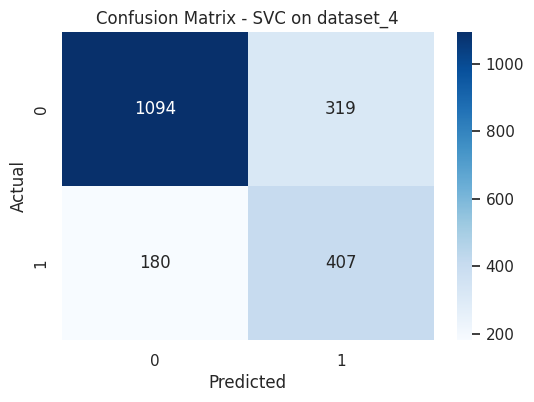

In [142]:
# train the SVC model
svc=SVC(kernel='rbf', probability=True)
train_and_evaluate_model(svc, X_train, X_test, y_train, y_test, 'dataset_4', 'SVC', results)

## Logistic Regression Model Training

Training LogisticRegression on dataset_4...
Performing 5-fold cross-validation for LogisticRegression on dataset_4...
Cross-validation metrics for LogisticRegression on dataset_4:
  cv_mean_accuracy: 0.7710
  cv_std_accuracy: 0.0041
Test metrics for LogisticRegression on dataset_4:
  accuracy: 0.7425
  precision: 0.5439
  recall: 0.7598
  f1: 0.6340
  roc_auc: 0.8339


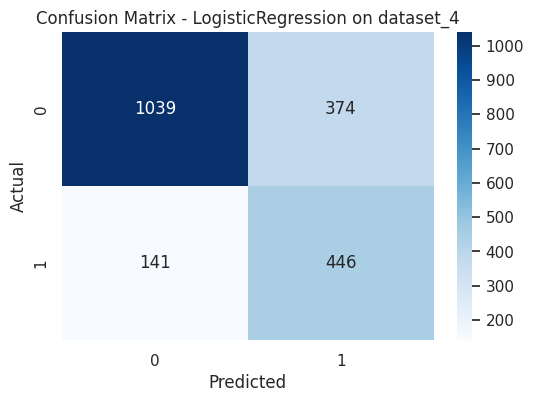

In [143]:
# train the LR model
lr = LogisticRegression(max_iter=200, class_weight='balanced', n_jobs=None)
train_and_evaluate_model(lr, X_train, X_test, y_train, y_test, 'dataset_4', 'LogisticRegression', results)

## XGBoost Model Training

Training XGBClassifier on dataset_4...
Performing 5-fold cross-validation for XGBClassifier on dataset_4...
Cross-validation metrics for XGBClassifier on dataset_4:
  cv_mean_accuracy: 0.7983
  cv_std_accuracy: 0.0216
Test metrics for XGBClassifier on dataset_4:
  accuracy: 0.5885
  precision: 0.4080
  recall: 0.8910
  f1: 0.5597
  roc_auc: 0.7665


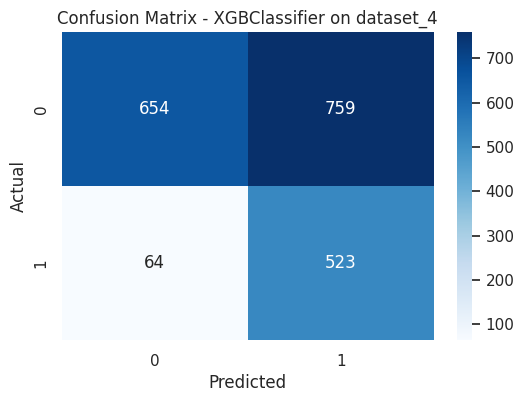

In [144]:
xgb=XGBClassifier(n_estimators=200, random_state=42)
train_and_evaluate_model(xgb, X_train, X_test, y_train, y_test, 'dataset_4', 'XGBClassifier', results)

# Results & Evaluation

In [145]:
# Create an empty list to store the results
results_list = []

# Iterate through the results dictionary
for dataset_name, models in results.items():
    for model_name, metrics_data in models.items():
        # Extract test metrics
        test_metrics = metrics_data['test_metrics']
        # Extract cross-validation metrics
        cv_metrics = metrics_data.get('cv_metrics', {}) # Use .get to handle cases where cv_metrics might be missing

        # Combine test and CV metrics
        all_metrics = {
            'dataset': dataset_name,
            'model': model_name,
            'accuracy': test_metrics.get('accuracy'),
            'precision': test_metrics.get('precision'),
            'recall': test_metrics.get('recall'),
            'f1': test_metrics.get('f1'),
            'roc_auc': test_metrics.get('roc_auc'),
            'cv_mean_accuracy': cv_metrics.get('cv_mean_accuracy'),
            'cv_std_accuracy': cv_metrics.get('cv_std_accuracy')
        }
        results_list.append(all_metrics)

# Convert the list of dictionaries to a pandas DataFrame
results_df = pd.DataFrame(results_list)

# Define the desired column order
desired_column_order = ['dataset', 'model', 'accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'cv_mean_accuracy', 'cv_std_accuracy']

# Reindex the DataFrame with the desired column order
results_df = results_df.reindex(columns=desired_column_order)

# Display the DataFrame
display(results_df)

,dataset,model,accuracy,precision,recall,f1,roc_auc,cv_mean_accuracy,cv_std_accuracy
0,dataset_1,RandomForest,0.791374,0.098958,0.351852,0.154472,0.742705,0.959103,0.018333
1,dataset_1,SVM,0.741224,0.095238,0.444444,0.156863,0.724549,0.859499,0.006817
2,dataset_1,LogisticRegression,0.737212,0.143836,0.777778,0.242775,0.845116,0.781003,0.007092
3,dataset_1,XGBClassifier,0.443330,0.084577,0.944444,0.155251,0.774518,0.955409,0.027218
4,dataset_2,RandomForest,0.767302,0.109649,0.462963,0.177305,0.752003,0.960686,0.018869
5,dataset_2,SVC,0.753260,0.100000,0.444444,0.163265,0.725168,0.860158,0.006727
6,dataset_2,LogisticRegression,0.740221,0.152542,0.833333,0.257880,0.842936,0.783773,0.005133
7,dataset_2,XGBClassifier,0.417252,0.082409,0.962963,0.151825,0.745493,0.956069,0.026202
8,dataset_3,RandomForest,0.767302,0.109649,0.462963,0.177305,0.752003,0.960686,0.018869
9,dataset_3,SVC,0.753260,0.100000,0.444444,0.163265,0.725168,0.860158,0.006727


In [146]:
results_df['prec_recall_gap'] = (results_df['precision'] - results_df['recall']).abs()
results_df['reliability'] = results_df['accuracy'] - results_df['cv_std_accuracy']

# Now groupby aggregation is simple
summary = results_df.groupby('model').agg(
    _mean=('accuracy','mean'),
    recall_mean=('recall','mean'),
    prec_recall_gap_mean=('prec_recall_gap','mean'),
    adaptability_std_cv_acc=('cv_mean_accuracy','std'),
    adaptability_std_f1=('f1','std'),
    robustness_std_composite=('cv_std_accuracy','std'),
    reliability_overall=('reliability','mean')
).reset_index()

summary = summary.round(3)
display(summary)

,model,_mean,recall_mean,prec_recall_gap_mean,adaptability_std_cv_acc,adaptability_std_f1,robustness_std_composite,reliability_overall
0,LogisticRegression,0.740,0.801,0.553,0.006,0.191,0.001,0.735
1,RandomForest,0.768,0.481,0.263,0.066,0.214,0.001,0.748
2,SVC,0.752,0.527,0.274,0.048,0.264,0.001,0.745
3,SVM,0.741,0.444,0.349,NaN,NaN,NaN,0.734
4,XGBClassifier,0.467,0.940,0.776,0.079,0.203,0.003,0.441


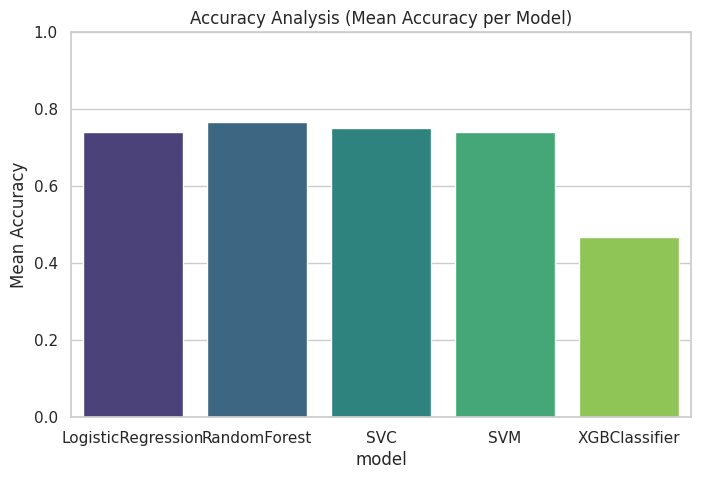

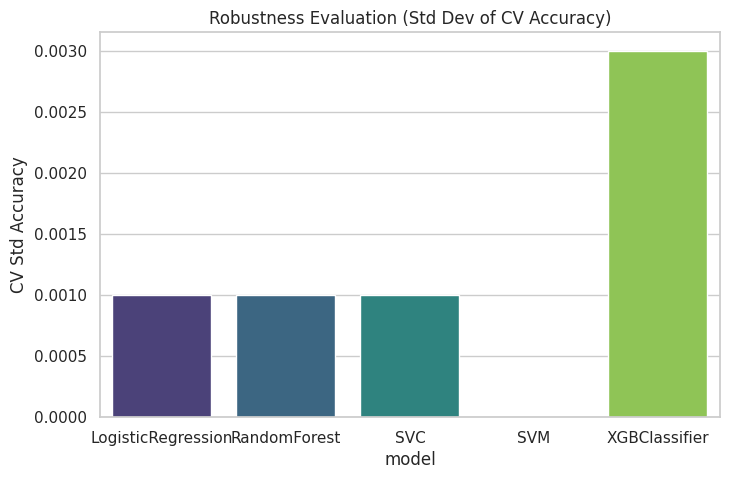

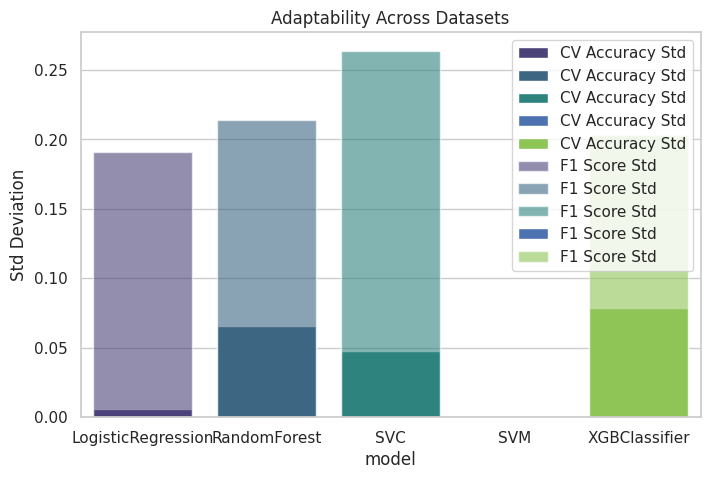

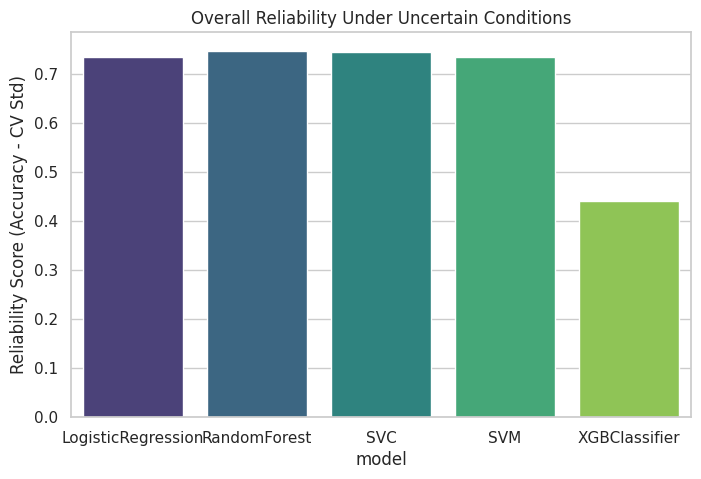

In [147]:

sns.set(style="whitegrid")  # clean background
colors = sns.color_palette("viridis", n_colors=len(summary))

# Accuracy Analysis
plt.figure(figsize=(8,5))
sns.barplot(data=summary, x='model', y='_mean', palette='viridis', hue='model')
plt.title('Accuracy Analysis (Mean Accuracy per Model)')
plt.ylabel('Mean Accuracy')
plt.ylim(0,1)
plt.show()

# Robustness Evaluation
plt.figure(figsize=(8,5))
sns.barplot(data=summary, x='model', y='robustness_std_composite', palette='viridis', hue='model')
plt.title('Robustness Evaluation (Std Dev of CV Accuracy)')
plt.ylabel('CV Std Accuracy')
plt.show()

# Adaptability Across Datasets
plt.figure(figsize=(8,5))
sns.barplot(data=summary, x='model', y='adaptability_std_cv_acc', palette='viridis', label='CV Accuracy Std', hue='model')
sns.barplot(data=summary, x='model', y='adaptability_std_f1', palette='viridis', alpha=0.6, label='F1 Score Std', hue='model')
plt.title('Adaptability Across Datasets')
plt.ylabel('Std Deviation')
plt.legend()
plt.show()

# Overall Reliability Under Uncertain Conditions
plt.figure(figsize=(8,5))
sns.barplot(data=summary, x='model', y='reliability_overall', palette='viridis', hue='model')
plt.title('Overall Reliability Under Uncertain Conditions')
plt.ylabel('Reliability Score (Accuracy - CV Std)')
plt.show()

# Combined Dataset Preprocessing and Training


## Combining The datasets

In [148]:
def to_snake(s: str) -> str:
    return (
        s.replace(" ", "_")
         .replace("-", "_")
         .replace("/", "_")
         .replace("__", "_")
         .strip()
         .lower()
    )

def standardize_and_select(df: pd.DataFrame, idx: int) -> pd.DataFrame:
    df = df.copy()
    df.columns = [to_snake(c) for c in df.columns]

    rename_map = {
        "avg_glucose": "avg_glucose_level",
        "id": "id",
    }
    df = df.rename(columns=rename_map)

    # Extended feature set (including ever_married and diabetes)
    core = [
        "gender",
        "age",
        "hypertension",
        "heart_disease",
        "ever_married",
        "avg_glucose_level",
        "bmi",
        "smoking_status",
        "diabetes",
        "stroke",
    ]

    # Fill in missing columns across datasets
    for col in core:
        if col not in df.columns:
            if col == "stroke":
                raise ValueError(f"Dataset {idx} has no 'stroke' column.")
            df[col] = np.nan

    df = df[core]

    # Normalize categorical and target formats
    df["gender"] = (
        df["gender"].astype(str).str.strip().str.lower()
          .replace({"m": "male", "f": "female", "nan": np.nan})
    )
    df["smoking_status"] = (
        df["smoking_status"].astype(str).str.strip().str.lower()
          .replace({"nan": np.nan})
    )
    df["ever_married"] = (
        df["ever_married"].astype(str).str.strip().str.lower()
          .replace({"yes": "yes", "no": "no", "nan": np.nan})
    )

    # Ensure diabetes column numeric (0/1) if available
    df["diabetes"] = pd.to_numeric(df["diabetes"], errors="coerce")

    # Target as integer 0/1
    df["stroke"] = pd.to_numeric(df["stroke"], errors="coerce").fillna(0).astype(int)

    return df


# Combine Dataset
df1 = standardize_and_select(data, 1)
df2 = standardize_and_select(data2, 2)
df3 = standardize_and_select(data3, 3)
df4 = standardize_and_select(data4, 4)

combined = pd.concat([df1, df2, df3, df4], ignore_index=True)
# show the first five rows of data sets
combined.head()

/tmp/ipython-input-1263216616.py:55: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace({"yes": "yes", "no": "no", "nan": np.nan})


,gender,age,hypertension,heart_disease,ever_married,avg_glucose_level,bmi,smoking_status,diabetes,stroke
0,1,67.0,0,1,1,3769.0,36.6,1,NaN,1
1,1,80.0,0,1,1,2444.0,32.5,2,NaN,1
2,0,49.0,0,0,1,3324.0,34.4,3,NaN,1
3,0,79.0,1,0,1,3333.0,24.0,2,NaN,1
4,1,81.0,0,0,1,3386.0,29.0,1,NaN,1


In [149]:
# names of the columns
combined.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'avg_glucose_level', 'bmi', 'smoking_status', 'diabetes', 'stroke'],
      dtype='object')

In [150]:
# check tha data types of data sets
combined.dtypes

,0
gender,object
age,float64
hypertension,int64
heart_disease,int64
ever_married,object
avg_glucose_level,float64
bmi,float64
smoking_status,object
diabetes,float64
stroke,int64


In [151]:
# check the info
combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63491 entries, 0 to 63490
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             63491 non-null  object 
 1   age                63491 non-null  float64
 2   hypertension       63491 non-null  int64  
 3   heart_disease      63491 non-null  int64  
 4   ever_married       53491 non-null  object 
 5   avg_glucose_level  63491 non-null  float64
 6   bmi                61828 non-null  float64
 7   smoking_status     63491 non-null  object 
 8   diabetes           10000 non-null  float64
 9   stroke             63491 non-null  int64  
dtypes: float64(4), int64(3), object(3)
memory usage: 4.8+ MB


In [152]:
# statistical summary of data set
combined.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,diabetes,stroke
count,63491.000000,63491.000000,63491.000000,63491.000000,61828.000000,10000.000000,63491.000000
mean,46.730992,0.174765,0.088847,3131.985255,28.528287,0.196000,0.067065
std,23.296226,0.379769,0.284525,3065.747589,7.314366,0.396988,0.250136
min,0.080000,0.000000,0.000000,0.000000,10.100000,0.000000,0.000000
25%,28.000000,0.000000,0.000000,215.000000,23.600000,0.000000,0.000000
50%,50.000000,0.000000,0.000000,2526.000000,27.900000,0.000000,0.000000
75%,66.000000,0.000000,0.000000,4546.000000,32.500000,0.000000,0.000000
max,99.417448,1.000000,1.000000,12542.000000,97.600000,1.000000,1.000000


In [153]:
# check the how many people have smooking status
combined['age'].value_counts()

,count
age,
51.000000,908
78.000000,902
52.000000,894
57.000000,877
53.000000,868
...,...
77.752514,1
76.767958,1
78.484925,1


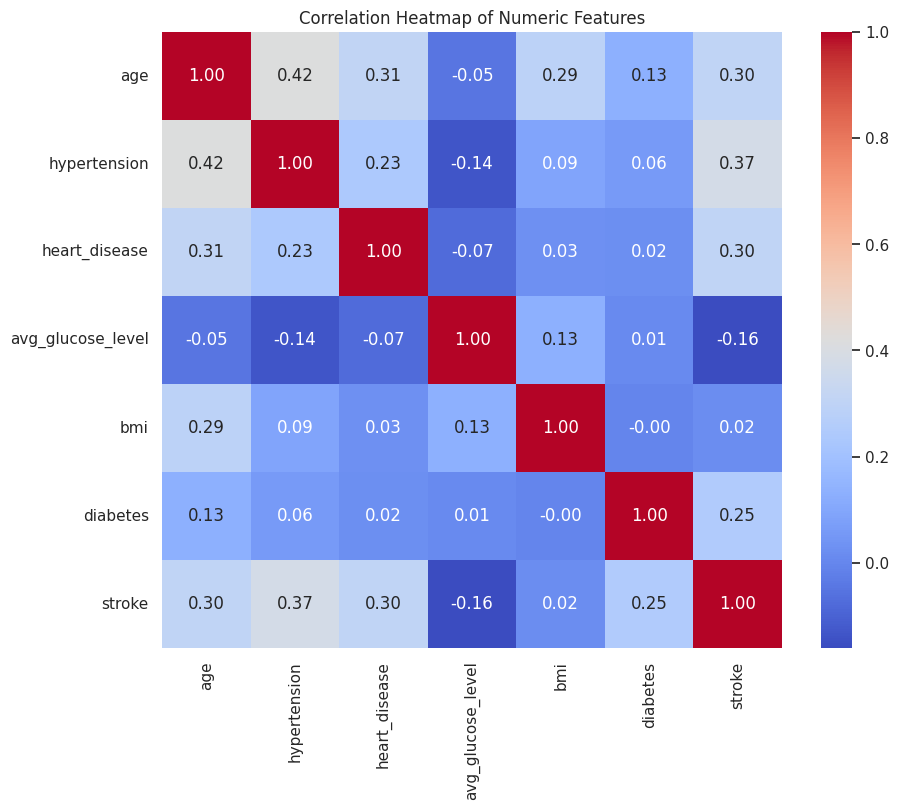

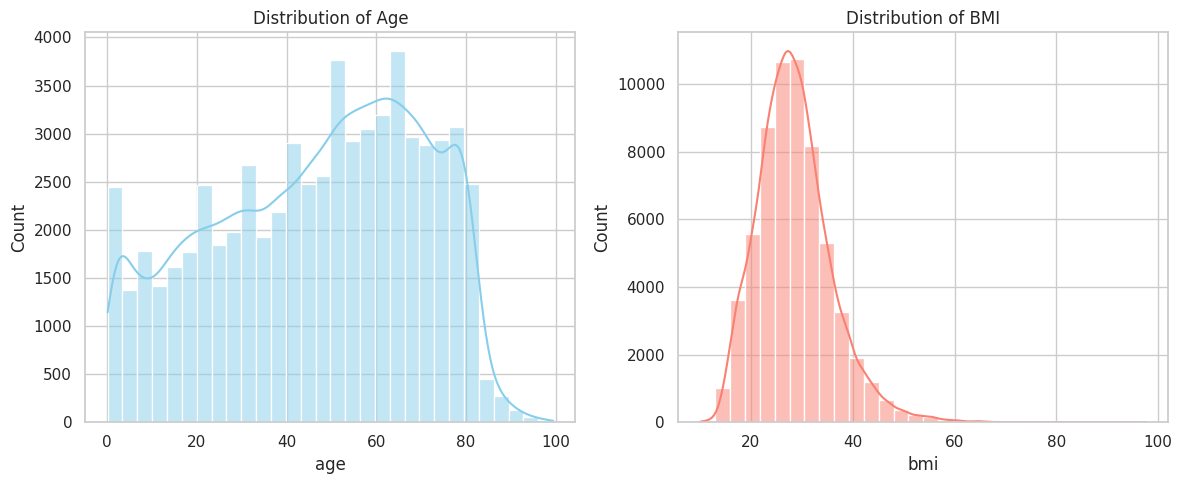

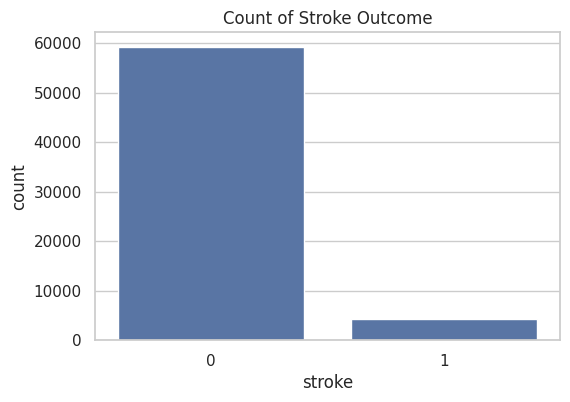

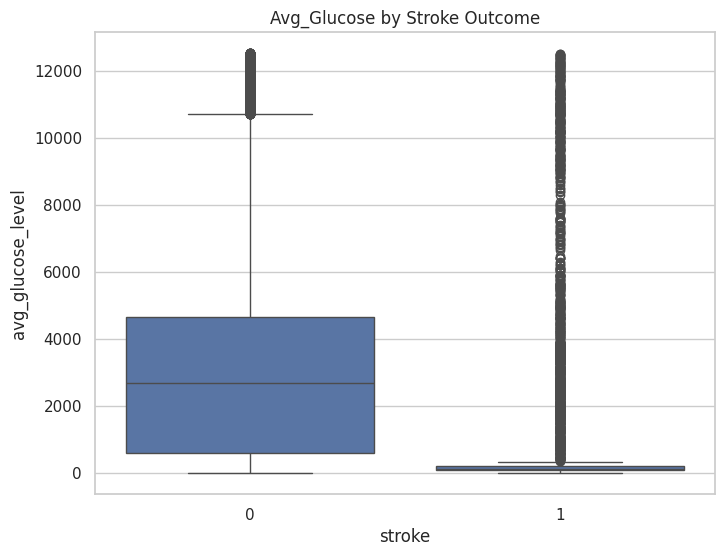

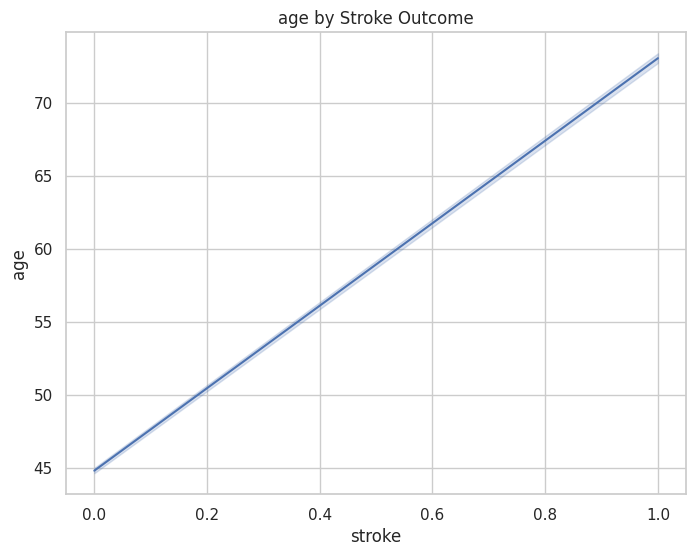

In [154]:
# Generate the correlation heatmap for numeric columns (if there are 4 or more)
numeric_data_combined=combined.select_dtypes(include=[np.number])
if numeric_data_combined.shape[1]>4:
    plt.figure(figsize=(10,8))
    corr=numeric_data_combined.corr()
    sns.heatmap(corr,annot=True,fmt='.2f',cmap='coolwarm')
    plt.title('Correlation Heatmap of Numeric Features')
    plt.show()

# Histogram for Age and BMI
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(combined['age'], kde=True, bins=30, color='skyblue')
plt.title('Distribution of Age')

plt.subplot(1, 2, 2)
sns.histplot(combined['bmi'], kde=True, bins=30, color='salmon')
plt.title('Distribution of BMI')
plt.tight_layout()
plt.show()

# Count plot for Stroke outcome
plt.figure(figsize=(6, 4))
sns.countplot(x='stroke', data=combined)
plt.title('Count of Stroke Outcome')
plt.show()

# Box plot for Avg_Glucose levels grouped by Stroke outcome
plt.figure(figsize=(8, 6))
sns.boxplot(x='stroke', y='avg_glucose_level', data=combined)
plt.title('Avg_Glucose by Stroke Outcome')
plt.show()

# Line plot for Age levels grouped by Stroke outcome
plt.figure(figsize=(8, 6))
sns.lineplot(x='stroke', y='age', data=combined)
plt.title('age by Stroke Outcome')
plt.show()

## RFC Model Training

In [155]:
# Preprocess and Train RandomForest
X = combined.drop(columns=["stroke"])
y = combined["stroke"]

cat_cols = ["gender", "smoking_status", "ever_married"]
num_cols = [c for c in X.columns if c not in cat_cols]

numeric_transformer = Pipeline([("imputer", SimpleImputer(strategy="median"))])
categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore")),
])

preprocess = ColumnTransformer([
    ("num", numeric_transformer, num_cols),
    ("cat", categorical_transformer, cat_cols),
])

rf = RandomForestClassifier(n_estimators=300, min_samples_split=4, min_samples_leaf=2, class_weight="balanced", random_state=42, n_jobs=-1)

clf = Pipeline([("preprocess", preprocess), ("rf", rf)])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

clf.fit(X_train, y_train)

# Evaluate
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]

report = classification_report(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)
pr_auc = average_precision_score(y_test, y_prob)
cm = confusion_matrix(y_test, y_pred)

print("\n=== Random Forest Results (Combined Datasets) ===")
print(report)
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"PR-AUC : {pr_auc:.4f}")

# Save Model for use in LLM
output_path="/content/drive/MyDrive/AIDatasets/rf_stroke_combined_model.joblib"
joblib.dump(clf, output_path)
print("\nModel saved to path")



=== Random Forest Results (Combined Datasets) ===
              precision    recall  f1-score   support

           0       0.96      0.97      0.97     11847
           1       0.58      0.49      0.53       852

    accuracy                           0.94     12699
   macro avg       0.77      0.73      0.75     12699
weighted avg       0.94      0.94      0.94     12699

ROC-AUC: 0.9123
PR-AUC : 0.5613

Model saved to path
